In [2]:
import tensorflow as tf

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

In [5]:
import datetime
#Getting the Data
start = datetime.datetime(2011, 11, 19)
end = datetime.datetime(2021, 11, 19)
df = pdr.get_data_yahoo("AAPL", start=start, end=end)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-11-18,13.532857,13.571071,13.388571,13.390714,11.497486,371938000
2011-11-21,13.228571,13.274286,13.068214,13.178929,11.315645,447980400
2011-11-22,13.250714,13.497500,13.247857,13.446786,11.545630,409021200
2011-11-23,13.375357,13.422857,13.102857,13.106786,11.253703,428271200
2011-11-25,13.157857,13.255357,12.975714,12.984643,11.148830,254760800


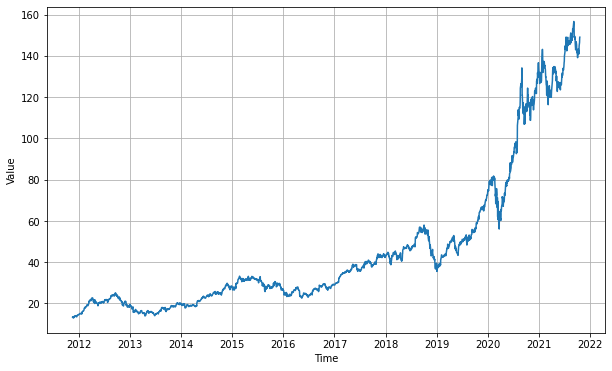

In [6]:
#series = AAPL['Close'].values.reshape(-1, 1)
#scaler = StandardScaler()
#scaler.fit(series[:len(series) // 2])
#series = scaler.transform(series).flatten()

series = np.array(df.Close)
time = np.array(df.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [7]:
split_time = 2000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2000,)
Epoch 1/100
8/8 [==============================] - 4s 146ms/step - loss: 48.1844 - mae: 48.6822
Epoch 2/100
8/8 [==============================] - 1s 143ms/step - loss: 47.2994 - mae: 47.7972
Epoch 3/100
8/8 [==============================] - 1s 141ms/step - loss: 45.8199 - mae: 46.3176
Epoch 4/100
8/8 [==============================] - 1s 152ms/step - loss: 43.8438 - mae: 44.3414
Epoch 5/100
8/8 [==============================] - 1s 153ms/step - loss: 41.3195 - mae: 41.8171
Epoch 6/100
8/8 [==============================] - 1s 140ms/step - loss: 38.0685 - mae: 38.5660
Epoch 7/100
8/8 [==============================] - 1s 144ms/step - loss: 33.7559 - mae: 34.2536
Epoch 8/100
8/8 [==============================] - 1s 142ms/step - loss: 28.8097 - mae: 29.3081
Epoch 9/100
8/8 [==============================] - 1s 137ms/step - loss: 24.6401 - mae: 25.1386
Epoch 10/100
8/8 [================

(1e-08, 0.0001, 0.0, 60.0)

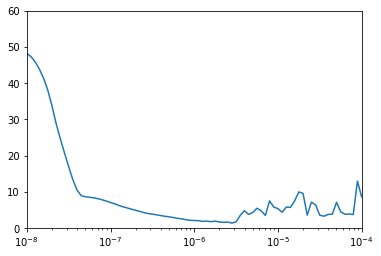

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=3e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
20/20 [==============================] - 3s 47ms/step - loss: 12.4611 - mae: 12.9519
Epoch 2/150
20/20 [==============================] - 1s 47ms/step - loss: 3.3854 - mae: 3.8524
Epoch 3/150
20/20 [==============================] - 1s 50ms/step - loss: 2.5279 - mae: 2.9889
Epoch 4/150
20/20 [==============================] - 1s 56ms/step - loss: 1.6205 - mae: 2.0547
Epoch 5/150
20/20 [==============================] - 1s 48ms/step - loss: 1.2046 - mae: 1.6172
Epoch 6/150
20/20 [==============================] - 1s 46ms/step - loss: 1.1526 - mae: 1.5776
Epoch 7/150
20/20 [==============================] - 1s 46ms/step - loss: 0.8495 - mae: 1.2376
Epoch 8/150
20/20 [==============================] - 1s 49ms/step - loss: 0.7712 - mae: 1.1465
Epoch 9/150
20/20 [==============================] - 1s 49ms/step - loss: 0.7045 - mae: 1.0710
Epoch 10/150
20/20 [==============================] - 1s 56ms/step - loss: 0.7435 - mae: 1.1260
Epoch 11/150
20/20 [===========================

In [13]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

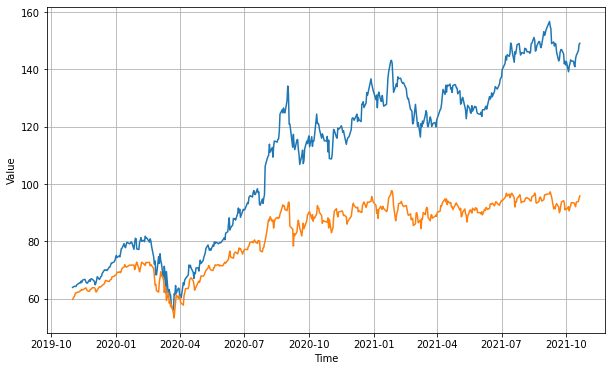

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

26.884245

In [16]:
print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[59.774757 61.0391   61.918365 62.120247 62.071198 62.283802 62.437893
 62.88145  62.921482 63.246735 63.07782  63.45821  63.689743 63.778484
 63.262062 62.75708  62.58581  63.234066 63.27751  63.84372  63.860416
 63.46871  62.42519  62.408237 63.039375 64.16976  64.05701  64.174934
 64.37284  64.65908  65.20911  65.995384 66.41096  66.344246 66.16552
 65.98801  66.516106 66.79449  67.66159  67.81296  68.15122  68.38368
 69.292175 69.18286  69.42674  69.07185  69.65282  70.56889  71.039825
 71.89044  71.419464 71.01095  71.130295 71.75413  71.667366 71.682625
 71.76444  71.73474  70.175865 70.93662  72.145805 72.77911  70.43946
 69.39911  70.56856  71.80303  72.76405  72.10518  72.079124 71.60872
 72.65562  72.61397  72.71135  71.51994  71.93954  71.558075 70.543495
 67.43602  64.77603  65.01058  62.777077 62.313072 65.87845  67.36428
 69.4145   67.972305 67.35115  62.19829  64.24261  63.975174 59.327362
 62.02758  58.46992  59.094154 57.23477  58.09024  54.89216  53.29503
 56.351696 5